**Créditos:** Esta atividade é uma adaptação dos tutoriais ATLAS-RECAST para o *US-ATLAS Computing Bootcamp* realizado no LBNL (*Lawrence Berkeley National Laboratory*) e na Universidade de Vitória  (*University of Victoria RECAST Bootcamp*).  A atividade  faz uso de conteúdo original desenvolvido por Danika MacDonell, Matthew Feickert, Lukas Heinrich, Karol Krizka, Samuel Meehan, Adam Parker e Giordon Stark.

# 1. O que é um container do docker?
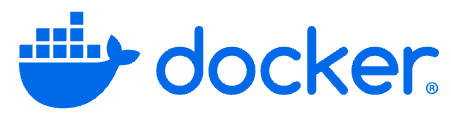

As imagens do Docker são executáveis ​​que agrupam todos os componentes necessários para um aplicativo ou ambiente em qualquer máquina host. Os containers do Docker são as instâncias de tempo de execução das imagens — são imagens com um estado.

É importante ressaltar que os containers compartilham o kernel do sistema operacional da máquina host e, portanto, não exigem um sistema operacional por aplicativo. Como processos discretos, os containers ocupam apenas a memória necessária, o que os torna muito leves e rápidos de executar.

Para maiores detalhes, visite o site oficial:

`https://docs.docker.com/get-started/`


Recomendamos também o módulo introdutório do HSF (*HEP Software Foundation*):

`https://hsf-training.github.io/hsf-training-docker/index.html`

# 2. "Puxando" as imagens

Para começar, vamos baixar a imagem do Docker com a qual trabalharemos nesta atividade:

**Bash**


`docker pull matthewfeickert/intro-to-docker`

e em seguida, vamos listar as imagens que estão disponíveis localmente:

**Bash**

`docker images`

Note o campo `TAG` associado à imagem `matthewfeickert/intro-to-docker`. As tags são uma maneira de especificar versões diferentes da mesma imagem. Como exemplo, vamos puxar a tag `buster` da imagem Debian.

**Bash**


`docker pull debian:buster`

`docker images debian`

# 3. Rodando containers

Para usar uma imagem Docker como uma instância específica em uma máquina host, você a executa como um container. Você pode executar em um modo desanexado (`detached`) ou em primeiro plano (`foreground`) de modo interativo.

Execute a imagem que "puxamos"  como um container interativo com flag  `-it`. Também queremos usar   `--rm` para garantir que, quando eventualmente deixarmos o container, a instância seja removida e não continue ocupando recursos em nossa máquina.

**Bash**

`docker run --rm -it matthewfeickert/intro-to-docker:latest /bin/bash`


Agora você está dentro do container em uma sessão `bash` interativa. Verifique o diretório do arquivo:

**Bash**

`pwd`

**Saída**

`/home/docker/data`

e verifique o host para ver se você não está no seu sistema host local:

**Bash**

`hostname`

# 4. Montagem de volume

Certifique-se de que saiu do container na sessão anterior, digitando:

**Bash**

`exit`

Você pode tornar arquivos e diretórios acessíveis ao container montando-os como volumes no container com o sinalizador `-v`. Isso permite acesso direto ao sistema de arquivos do host dentro do container e para que os processos do container gravem diretamente no sistema de arquivos do host.

**Bash**

`docker run -v <caminho no host>:<caminho dentro do container> <imagem>`

Por exemplo, para montar seu diretório de trabalho atual em sua máquina local no diretório `data` do contêiner do exemplo:

**Bash**

`docker run --rm -it -v $PWD:/home/docker/data matthewfeickert/intro-to-docker`

De dentro do container você pode listar `ls`  para ver o conteúdo do seu diretório na sua máquina local:

**Bash**

ls

e ainda assim você está dentro do container:


**Bash**

`pwd`

**Saída**

`/home/docker/data`


Agora vamos verificar que todos os arquivos criados neste caminho no container persistem na saída:

**Bash**

`touch arquivo_criado_dentro.txt`

`exit`

**Bash**

`ls *.txt`

**Saída**

`arquivo_criado_dentro.txt`


Você pode ter notado que o comando de inicialização `/bin/bash` foi usado para iniciar o container em um `shell bash` quando executamos o `matthewfeickert/intro-to-docker:latest` pela primeira vez, mas na segunda vez que executamos o container (quando adicionamos o `-v $PWD:/home/docker/data`), não especificamos um comando de inicialização. Como o container ainda sabia que deveria iniciar em um `shell bash`?

O docker não tem essa funcionalidade. Contudo, esse comportamento vem do fato de que o  ([Dockerfile](https://hub.docker.com/r/matthewfeickert/intro-to-docker/dockerfile)) usado para criar essa imagem inclui uma instrução CMD [`/bin/bash`] no final, onde o comando CMD especifica que o container deve iniciar no  por padrão `shell bash` se nenhum outro comando de inicialização for especificado no comando `docker run`.

# 5. Escrevendo arquivos Docker (Dockerfiles) para construir imagens

As imagens do Docker são construídas por meio do mecanismo do Docker, que lê as instruções de um `Dockerfile`. Esses documentos baseados em texto fornecem as instruções por meio de uma API semelhante aos comandos do sistema operacional Linux para executar comandos durante a construção (`build`). O `Dockerfile` para a imagem  que está sendo usada é um exemplo de algumas extensões simples da imagem oficial do Docker do Python 3.6.8 ( [Dockerfile Python 3.6.8](https://hub.docker.com/layers/library/python/3.6.8/images/sha256-d5028edbd2793f03125e76c0519b837306b63d7835efd8e7aa62b9d46126a495)).

Certifique-se de que saiu do container na sessão anterior, digitando:

**Bash**

`exit`


Agora vamos de maneira muito simples estender a imagem do exemplo que estamos utilizando em uma nova imagem.  Para isso, crie um `Dockerfile` em sua máquina local:

**Bash**

`touch Dockerfile`

E escreva nele as seguintes intruções  do  Docker para adicionar `cowsay` e `scikit-learn` ao ambiente:



```
# Dockerfile
FROM matthewfeickert/intro-to-docker:latest
USER root
RUN apt-get update && \
    apt-get -qq -y install cowsay && \
    ln -s /usr/games/cowsay /usr/bin/cowsay
RUN python -m pip install --no-cache-dir -q scikit-learn
USER docker
```



## Camadas do `Dockerfile`

Cada comando `run` em um Dockerfile cria uma nova camada para a imagem Docker. Em geral, cada camada deve tentar fazer um trabalho e quanto menos camadas houver em uma imagem, mais fácil será compactá-la. Ao tentar carregar e baixar imagens sob demanda, quanto menor o tamanho, melhor.



Em seguida, crie uma imagem a partir do Dockerfile e marque-a com um nome legível por humanos:

**Bash**

`docker build -f Dockerfile -t extend-example:latest .`

Agora você pode executar a imagem como container e verificar por si mesmo se aquilo que você adicionou existe:

**Bash**

`docker run --rm -it extend-example:latest /bin/bash`

**Bash**



```
which cowsay
cowsay "Hello from Docker"
python -m pip list | grep scikit
python3 -c "import sklearn as sk; print(sk)"
```



**Saída**



```
/usr/bin/cowsay
 ___________________
< Hello from Docker >
 -------------------
        \   ^__^
         \  (oo)\_______
            (__)\       )\/\
                ||----w |
                ||     ||

scikit-learn       0.21.3
<module 'sklearn' from '/usr/local/lib/python3.6/site-packages/sklearn/__init__.py'>
```



# 6. Resumindo o que aprendemos nesta etapa



*   Os containeres oferecem uma maneira rápida e acessível de personalizar seu ambiente.
*   Dockerfiles permitem que você personalize uma imagem docker base para obter o ambiente exato que você deseja.
*   A montagem de volume permite que você especifique os arquivos e diretórios exatos em sua máquina local para os quais você deseja que um container em execução tenha acesso.